# Свёрточные сети

Семинар в колабе
https://colab.research.google.com/drive/1Vf24aCwcdLA2ge9XoMCyGKwU_M2eeQrr?usp=sharing

На семинаре мы ближе познакомимся с основным инструментом для работы с изображениями — **свёрточными сетями (convolutional neural network, CNN)**. Ниже, в качестве примера такой сети, представлена сеть [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) для распознавания рукописных знаков.

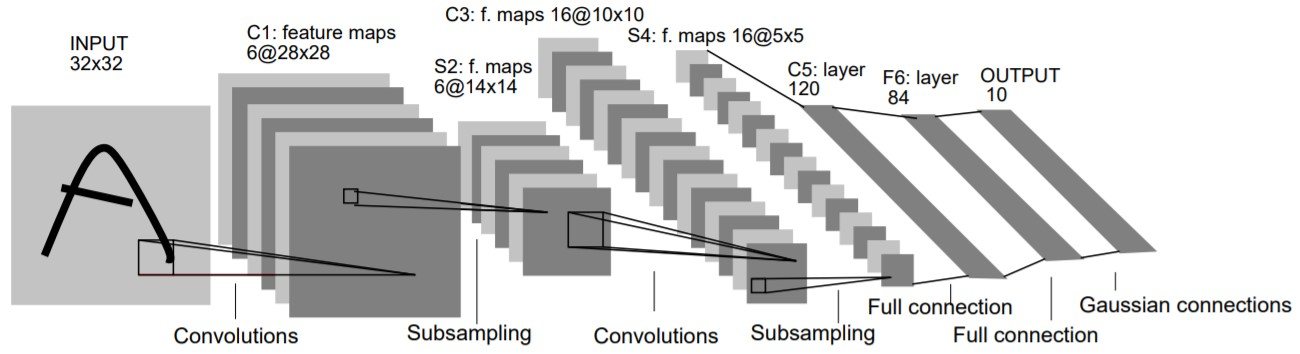

Простейшая архитектура **CNN** для классификации изображений состоит из последовательности чередующихся **свёрточных** и **пулинговых** слоёв (**pooling layer**, **subsamling**), которая завершается **полносвязными слоями (fully connected layer)**, образующими **многослойный перцептрон** (**multilayer perceptron**, **MLP**). **MLP** часто называют "головой" сети.

Функционально, свёрточная часть сети извлекает признаки из изображения, а MLP предсказывает его класс.

**План семинара:**
1. Cвёрточный слой и его параметры
- Пуллинговый слой
- Подготавливаем данные
- Простая архитектура свёрточной сети
- Обучаем сеть
- Визуализируем параметры сети
- Полезные материалы

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Cвёрточный слой и его параметры

В PyTorch свёрточный слой представлен в модуле `nn` функцией [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) с параметрами:
- количество входных каналов `in_channels`
- количество выходных каналов `out_channels`
- размер ядра `kernel_size`
- шаг `stride`
- паддинг `padding`
- режим паддинга `padding_mode` (`'zeros'`, `'reflect'` и др.)
- `dilation`

**Размер ядра** - `int`, если ядро квадратное и кортеж из двух чисел, если ядро прямоугольное. Задает размер фильтра, с которым производится свертка изображения.

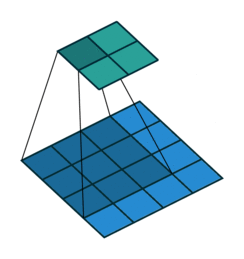

Эта и следующие анимации взяты [здесь](https://github.com/vdumoulin/conv_arithmetic)

**Шаг** - задает шаг, в пикселях, на который сдвигается фильтр. `int`, если по горизонтали и вертикали сдвигается на одно и то же число. Кортеж из двух чисел, если сдвиги разные.

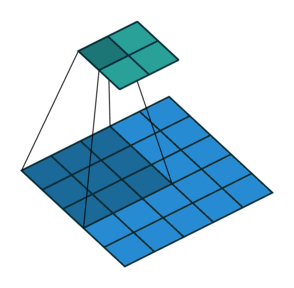

Шаг: 2

**Паддинг** - количество пикселей, которыми дополняется изображение. Аналогично шагу и размеру ядра, может быть, как `int`, так и кортежем из двух чисел.

**Произвольный паддинг**
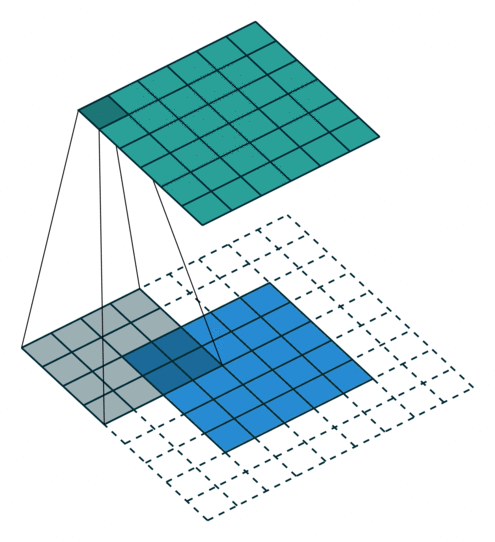

**Half pading**


**Full padding**
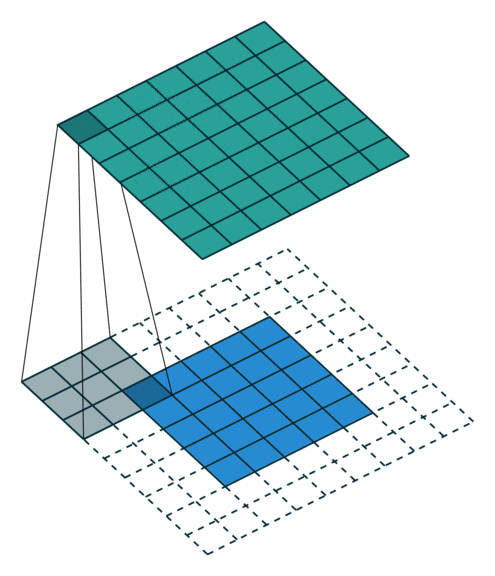

**Режим паддинга** позволяет выбрать значения пикселей, которыми дополняется изображение:
- `zeros` нулями
- `reflect` отражает изображение, относительно граничных пикселей
- `replicate` копирует изображение, после чего отражает и состыковывает с изначальным

**Reflection padding**
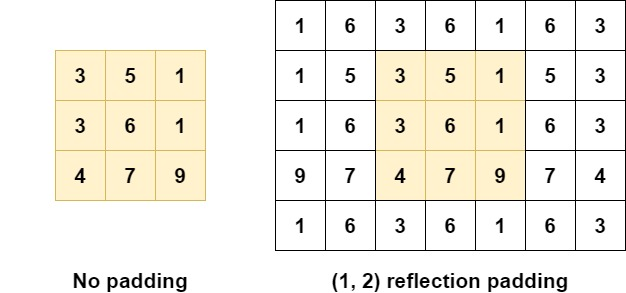

**Replication padding**
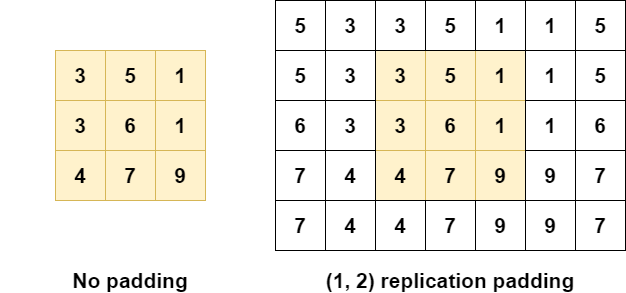

**Dilation**

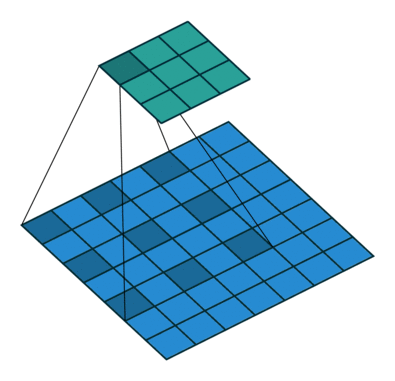

## Пулинговый слой

Для пулинга в PyTorch можно использовать слои, реализованные в модуле `nn`:
- [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
- [AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html#torch.nn.AvgPool2d)

Для них тоже можно задавать размер ядра, шаг и паддинг.

Пример использования max pooling с ядром 2х2 и шагом 2
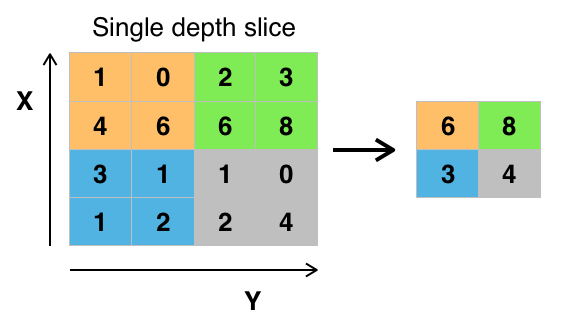

## Подготавливаем данные

Прежде чем перейти к построению архитектуры CNN давайте загрузим и подготовим данные. Будем работать с набором данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), в котором содержатся изображения 10 классов размером 32 на 32 пикселя с тремя каналами. В тренировочной выборке 50000 изображений, а в тестовой 10000.

Теперь опишем трансформации, которые мы хотим произвести с изображениями.
Полный список доступных преобразований можно найти [тут](https://pytorch.org/docs/stable/torchvision/transforms.html).

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), # Преобразуем изображние в тензор
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Нормализуем тензор изображения по каждому каналу

Загружаем данные и создаем `dataloader`'ы

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
assert False

AssertionError: 

Давайте посмотрим на несколько тестовых изображений

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [10]:
images[0].shape

torch.Size([3, 32, 32])

In [6]:
def imshow(img):
    img = img / 2 + 0.5  # Убираем нормализацию
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Получаем изображения и их метки классов
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

plane horse  bird   car


## Простая архитектура свёрточной сети

Для нашей задачи подойдет простая архитектура:
1. Свёрточный слой с 6 выходными каналами и ядром 5х5
- Max pooling с ядром 2х2 и шагом 2
- Свёрточный слой с 16 выходными каналами и ядром 5х5
- Max pooling с ядром 2х2 и шагом 2
- Полносвязыный слой со 120 выходами
- Полносвязыный слой с 84 выходами
- Полносвязыный слой с 10 выходами

После каждого свёрточного и полносвзяного слоя (кроме последнего) будем использовать функцию активации ReLU.

Задайте такую сеть. Для свёрточных слоев задайте метки `conv1`, `conv2` и т.д.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # your code here

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        
        x = # your code here
        
        # Ваш код здесь
        
        return out
    
    
model = SimpleCNN()

## Обучаем сеть

В качестве функции потерь будем использовать [`CrossEntropyLoss()`](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html). Оптимизировать будем с помощью [`SGD()`](https://pytorch.org/docs/stable/optim.html?highlight=sgd#torch.optim.SGD) с параметрами `lr=0.001` и `momentum=0.9`.

In [ ]:
# Ваш код здесь
# Задаем критерий
criterion = # your code here

# Инициализируем оптимизатор
optimizer = # your code here

for epoch in range(2):

    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # Ваш код здесь
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        # Печатаем статистику обучения
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение завершено')

Проверим какие результаты наша модель показывает на тестовых данных.

In [ ]:
correct = 0
total = 0

with torch.no_grad(): # Отключает рассчет градиентов
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # Возвращает индекс класса с максимальным значением
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Доля верных ответов на тестовых данных: %d %%' % (
    100 * correct / total))

**Задание.** Поэкспериментируйте с архитектурой сети и добейтесь лучших результатов.

## Визуализируем параметры сети

In [ ]:
from filter_viz import plot_filters

Давайте посмотрим, какие фильтры выучивает сеть, для этого функции `plot_filters()` надо передать свёрточный слой, фильтры которого мы визуализируем.

Параметр `single_channel` при значении `True` позволяет отображать каждый фильтр независимо, в итоге получается `in_channels` * `out_channels` фильтров. При `single_channel=False`позволяет визуализировать как RGB изображение (работает только при `in_channels=3)`.

In [ ]:
plot_filters(model.conv1, single_channel=False)

In [ ]:
plot_filters(model.conv1, single_channel=True)

In [ ]:
plot_filters(model.conv2, single_channel=True)

## Полезные материалы

1. A guide to convolution arithmetic for deep learning [paper](https://arxiv.org/abs/1603.07285) [github](https://github.com/vdumoulin/conv_arithmetic)